##Project Churning




In [ ]:
! pip install imbalanced-learn
! pip install shap 
! pip3 install visualkeras
! pip install numpy
! pip install pandas
! pip install scipy
! pip install matplotlib
! pip install keras
! pip install tensorflow
! pip install xgboost
! pip install catboost

     |████████████████████████████████| 358kB 19.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491625 sha256=5b525bebf252f22408974d46775b7962ac12a78a457402fda5c459848d370c97
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 67.3MB 49kB/s 


## Import


In [ ]:
from sklearn import *
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, plot_roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import xgboost as xgb

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
shap.initjs()

## Load and Preprocess Data

In [ ]:
train = pd.read_csv("/train.csv")
test = pd.read_csv("/test.csv")


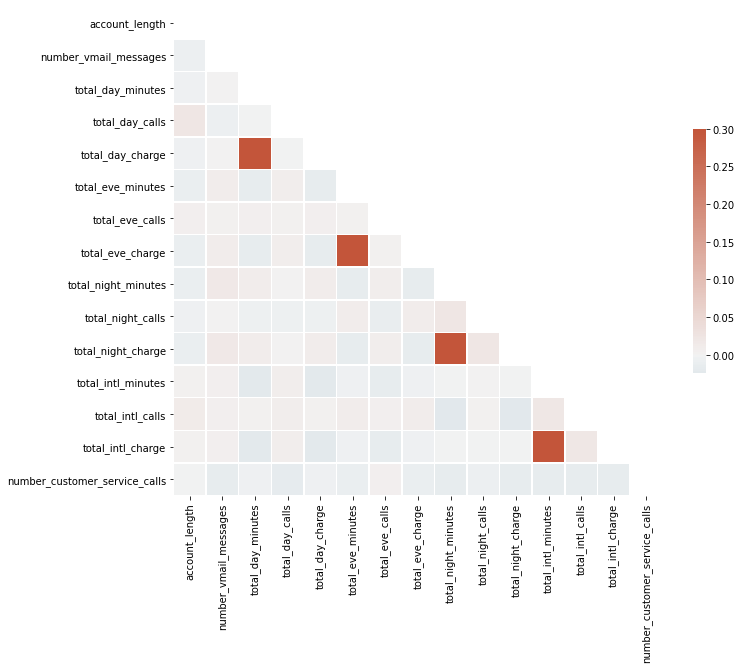

In [ ]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
def preprocess(df, testing=False):
  if not testing:
    df.loc[df["churn"]=="no", "churn"] = 0
    df.loc[df["churn"]=="yes", "churn"] = 1
  else:
    df.drop("id", axis = 1, inplace = True )
  df.drop("state", axis = 1, inplace = True )
  df = pd.get_dummies(df, columns=["area_code", "voice_mail_plan", "international_plan"], drop_first=True)
  return df

In [ ]:
train_1 = preprocess(train)
test_1 = preprocess(test, testing=True)
train_y = train_1["churn"]
train_x = train_1.drop("churn", axis=1)

In [ ]:
len(train_y.values)

4250

## SMOTE

In [ ]:
smote = SMOTE(ratio='minority')
train_x_smote, train_y_smote = smote.fit_sample(train_x, train_y.values)


'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [ ]:
len(train_y_smote)

7304

## Scaling

In [ ]:
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_1 = scaler.transform(test_1)

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x_smote, train_y_smote, test_size = 0.25, random_state = 5)

## Nueral Network Model

In [ ]:
model = Sequential([tf.keras.layers.BatchNormalization(input_shape = train_x.shape[1:]),
                    tf.keras.layers.Dense(360, activation= "elu", kernel_initializer="he_normal"),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(270, activation= "elu", kernel_initializer="he_normal"),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(200, activation= "elu", kernel_initializer="he_normal"),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(120, activation= "relu"),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(80, activation= "relu"),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(50, activation= "relu"),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(1, activation= "sigmoid")
                    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 19)                76        
_________________________________________________________________
dense (Dense)                (None, 360)               7200      
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 360)               1440      
_________________________________________________________________
dense_1 (Dense)              (None, 270)               97470     
_________________________________________________________________
dropout_1 (Dropout)          (None, 270)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 270)               1

In [ ]:
import visualkeras
visualkeras.layered_view(model, to_file='output.png', draw_funnel=True)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

In [ ]:
history = model.fit(train_x, train_y.astype('float32'), epochs=100,validation_data=(valid_x, valid_y.astype('float32')), callbacks= [early_stopping_cb])

Epoch 1/100
172/172 [==============================] - 6s 9ms/step - loss: 0.6366 - accuracy: 0.6754 - val_loss: 1.3963 - val_accuracy: 0.6857
Epoch 2/100
172/172 [==============================] - 1s 7ms/step - loss: 0.4106 - accuracy: 0.8253 - val_loss: 0.3631 - val_accuracy: 0.8516
Epoch 3/100
172/172 [==============================] - 1s 7ms/step - loss: 0.3981 - accuracy: 0.8331 - val_loss: 0.3210 - val_accuracy: 0.8686
Epoch 4/100
172/172 [==============================] - 1s 7ms/step - loss: 0.3824 - accuracy: 0.8501 - val_loss: 0.2850 - val_accuracy: 0.8866
Epoch 5/100
172/172 [==============================] - 1s 7ms/step - loss: 0.3538 - accuracy: 0.8476 - val_loss: 0.2663 - val_accuracy: 0.8970
Epoch 6/100
172/172 [==============================] - 1s 7ms/step - loss: 0.3206 - accuracy: 0.8728 - val_loss: 0.2637 - val_accuracy: 0.8965
Epoch 7/100
172/172 [==============================] - 1s 7ms/step - loss: 0.3318 - accuracy: 0.8646 - val_loss: 0.2740 - val_accuracy: 0.8877

In [ ]:
pred = model.predict_classes(valid_x)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
accuracy_score(valid_y.astype("int"), pred.reshape(1826, ).astype("int"))

0.9561883899233297

In [ ]:
precision_score(valid_y.astype("int"), pred.reshape(1826, ).astype("int"))


0.9629629629629629

## TPot

Generation 1 - Current best internal CV score: 0.9574117647058824

Generation 2 - Current best internal CV score: 0.9595294117647057

Generation 3 - Current best internal CV score: 0.9614117647058823

Generation 4 - Current best internal CV score: 0.9614117647058823

Generation 5 - Current best internal CV score: 0.9614117647058823

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.9500000000000001, min_samples_leaf=3, min_samples_split=4, n_estimators=100)
TPOTClassifier(generations=5, n_jobs=-1, random_state=2, scoring='accuracy',
               verbosity=2)

## Tree based Method

In [ ]:
tree_model = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.95, min_samples_leaf=3, min_samples_split=4, n_estimators=100)

In [ ]:
tree_model.fit(X = train_x ,y=train_y.astype('int'))

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features=0.95,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
pred = tree_model.predict(valid_x)
print("Accuracy : ", accuracy_score(valid_y.astype('int'), pred))
print("Precision Score : ", precision_score(valid_y.astype('int'), pred))

Accuracy :  0.9731653888280394
Precision Score :  0.9856670341786108


In [ ]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(train_x)

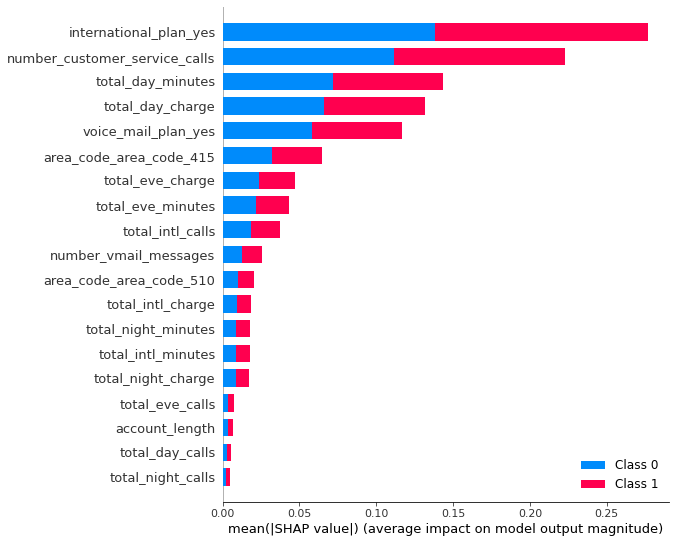

In [ ]:
shap.summary_plot(shap_values, list(test_1.columns))
#shap.plots.beeswarm(shap_values)

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


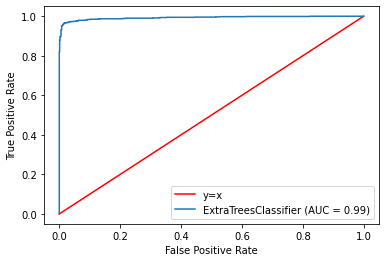

In [ ]:

x = np.linspace(0,1,100)
y = x
plt.plot(x, y, '-r', label='y=x')
ax = plt.axes()
plot_roc_curve(tree_model, valid_x, valid_y.astype('int'), drop_intermediate=False, ax = ax)

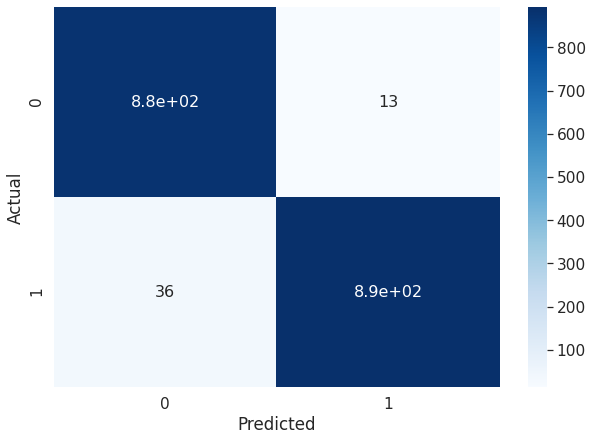

In [ ]:
cm = confusion_matrix(valid_y.astype('int'), pred)
df_cm = pd.DataFrame(cm, columns=np.unique(valid_y.astype('int')), index = np.unique(valid_y.astype('int')))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## SVM

In [ ]:
svm_class = SVC()
svm_class.fit(X = train_x ,y=train_y.astype('int'))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
pred = svm_class.predict(valid_x)
print("Accuracy : ", accuracy_score(valid_y.astype('int'), pred))
print("Precision Score : ", precision_score(valid_y.astype('int'), pred))

Accuracy :  0.7009857612267251
Precision Score :  0.8568773234200744


In [ ]:
explainer = shap.KernelExplainer(svm_class.predict, shap.sample(train_x, 50))
shap_values = explainer.shap_values(train_x, nsamples=100)

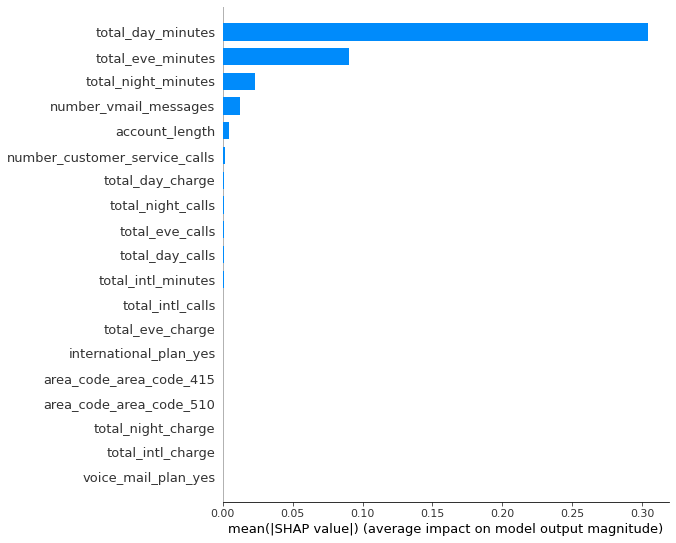

In [ ]:
shap.summary_plot(shap_values, list(test_1.columns), plot_type="bar")
#shap.plots.beeswarm(shap_values)

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


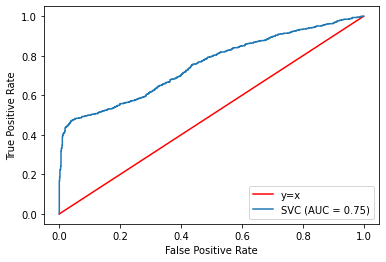

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0,1,100)
y = x
plt.plot(x, y, '-r', label='y=x')
ax = plt.axes()
plot_roc_curve(svm_class, valid_x, valid_y.astype('int'), drop_intermediate=False, ax = ax)

## XGboost

In [ ]:
import xgboost as xgb


In [ ]:
xgb_model_fit = xgb.XGBClassifier(n_jobs=-1)
xgb_model_fit.fit(train_x, train_y,
              eval_set = [(train_x, train_y), (valid_x, valid_y)])

[0]	validation_0-error:0.132895	validation_1-error:0.145126
[1]	validation_0-error:0.132895	validation_1-error:0.145126
[2]	validation_0-error:0.132895	validation_1-error:0.145126
[3]	validation_0-error:0.114458	validation_1-error:0.125411
[4]	validation_0-error:0.114458	validation_1-error:0.125411
[5]	validation_0-error:0.114458	validation_1-error:0.125411
[6]	validation_0-error:0.114458	validation_1-error:0.125411
[7]	validation_0-error:0.114458	validation_1-error:0.125411
[8]	validation_0-error:0.114458	validation_1-error:0.125411
[9]	validation_0-error:0.110989	validation_1-error:0.120482
[10]	validation_0-error:0.113363	validation_1-error:0.124315
[11]	validation_0-error:0.110259	validation_1-error:0.118839
[12]	validation_0-error:0.110259	validation_1-error:0.118839
[13]	validation_0-error:0.109529	validation_1-error:0.117744
[14]	validation_0-error:0.110259	validation_1-error:0.118839
[15]	validation_0-error:0.108434	validation_1-error:0.117744
[16]	validation_0-error:0.108799	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pred = xgb_model.predict(valid_x)
print("Accuracy : ", accuracy_score(valid_y.astype('int'), pred.astype('int')))
print("Precision Score : ", precision_score(valid_y.astype('int'), pred.astype('int')))

Accuracy :  0.9556407447973713
Precision Score :  0.9785794813979707


## Catboost

In [ ]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier()
cat_model.fit(train_x, train_y)

Learning rate set to 0.021297
0:	learn: 0.6732267	total: 55.5ms	remaining: 55.5s
1:	learn: 0.6543624	total: 62.6ms	remaining: 31.2s
2:	learn: 0.6368024	total: 68.9ms	remaining: 22.9s
3:	learn: 0.6200208	total: 75.5ms	remaining: 18.8s
4:	learn: 0.6042768	total: 82.1ms	remaining: 16.3s
5:	learn: 0.5890043	total: 88.6ms	remaining: 14.7s
6:	learn: 0.5743020	total: 95.1ms	remaining: 13.5s
7:	learn: 0.5603019	total: 101ms	remaining: 12.6s
8:	learn: 0.5482625	total: 108ms	remaining: 11.9s
9:	learn: 0.5383316	total: 114ms	remaining: 11.3s
10:	learn: 0.5272892	total: 121ms	remaining: 10.9s
11:	learn: 0.5173058	total: 128ms	remaining: 10.5s
12:	learn: 0.5069359	total: 134ms	remaining: 10.2s
13:	learn: 0.4968284	total: 140ms	remaining: 9.87s
14:	learn: 0.4888357	total: 147ms	remaining: 9.63s
15:	learn: 0.4790373	total: 156ms	remaining: 9.6s
16:	learn: 0.4691546	total: 165ms	remaining: 9.56s
17:	learn: 0.4593581	total: 174ms	remaining: 9.47s
18:	learn: 0.4505255	total: 181ms	remaining: 9.35s
19:	l

In [ ]:
pred = cat_model.predict(valid_x)
print("Accuracy : ", accuracy_score(valid_y.astype('int'), pred.astype('int')))
print("Precision Score : ", precision_score(valid_y.astype('int'), pred.astype('int')))

Accuracy :  0.9780941949616648
Precision Score :  0.9879385964912281
